Random Forest Regression Algorithm for NFL play-calling analysis
Econ 337

In [2]:
import pandas as pd
import matplotlib
from sklearn import preprocessing
%matplotlib inline
df = pd.read_csv('playByPlay.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(449371, 255)

In [15]:
#filtering rows
sfdf = df[(df.posteam=='SF') & (df.down.isin([1.0,2.0,3.0,4.0])) & 
          ((df.play_type == 'run') | (df.play_type == 'pass'))]
#filter columns
sfdf = sfdf[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo',
            'shotgun', 'score_differential', 'play_type', 'pass_length',
            'pass_location', 'run_location']]
sfdf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location
1721,3456.0,74.0,1.0,10,0,0.0,run,NaN,NaN,right
1722,3415.0,76.0,2.0,12,1,0.0,run,NaN,NaN,middle
1723,3376.0,79.0,3.0,15,1,0.0,pass,short,right,NaN
1730,3184.0,36.0,1.0,10,0,0.0,pass,short,left,NaN
1732,3125.0,23.0,1.0,10,0,0.0,run,NaN,NaN,right


In [16]:
import numpy as np
#This function categorizes pass and run plays by type
def get_full_play_type(play):
    play_type, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+run_location
    else:
        return play_type+'_'+pass_location
#This command replaces missing values
sfdf = sfdf.replace(np.nan, 'unknown', regex=True)
sfdf['full_play_type'] = sfdf[['play_type', 'pass_location', 'run_location']].apply(get_full_play_type, axis=1)
sfdf = sfdf[(sfdf.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left','run_middle','run_right']))]

In [17]:
sfdf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,full_play_type
1721,3456.0,74.0,1.0,10,0,0.0,run,unknown,unknown,right,run_right
1722,3415.0,76.0,2.0,12,1,0.0,run,unknown,unknown,middle,run_middle
1723,3376.0,79.0,3.0,15,1,0.0,pass,short,right,unknown,pass_right
1730,3184.0,36.0,1.0,10,0,0.0,pass,short,left,unknown,pass_left
1732,3125.0,23.0,1.0,10,0,0.0,run,unknown,unknown,right,run_right


In [18]:
#Analyzing the data to find potential patterns
sfdf.groupby(['full_play_type']).count()[['play_type']]

,play_type
full_play_type,
pass_left,1806
pass_middle,979
pass_right,2108
run_left,1603
run_middle,1252
run_right,1384


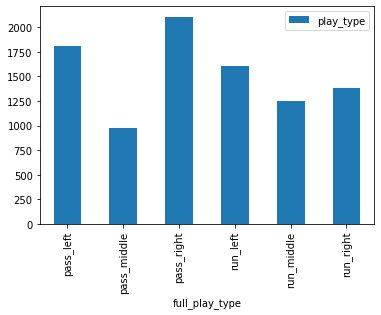

In [19]:
#creating a bar chart
sfdf.groupby(['full_play_type']).count()[['play_type']].plot(kind='bar')

In [21]:
#normalizing play type and location
sfdf.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100*x/float(x.sum()))

,play_type
full_play_type,
pass_left,19.776610
pass_middle,10.720543
pass_right,23.083662
run_left,17.553657
run_middle,13.710031
run_right,15.155497


In [22]:
#scikit learn preprocessing converts data to numeric
le = preprocessing.LabelEncoder()
le.fit(sfdf.full_play_type)
sfdf['full_play_type_code'] = le.transform(sfdf['full_play_type'])

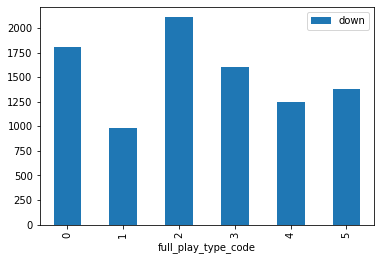

In [23]:
#creating a new bar chart
sfdf.groupby(['full_play_type_code']).count()[['down']].plot(kind='bar')

In [28]:
#creating categorical containers according to distance of play
def container(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def container_df(df):
    df['ydstogo'] = [container(x, 4, 5) for x in df['ydstogo']]
    return df

#creating dummies
sfdf = container_df(sfdf)
sfdf = pd.concat([sfdf, pd.get_dummies(sfdf['down'], prefix='down')], axis=1)
sfdf = pd.concat([sfdf, pd.get_dummies(sfdf['ydstogo'], prefix='ydstogo')], axis=1)

In [29]:
sfdf.describe()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,full_play_type_code,down_1.0,down_2.0,down_3.0,...,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0
count,9132.000000,9132.000000,9132.000000,9132.0,9132.000000,9132.000000,9132.000000,9132.00000,9132.000000,9132.000000,...,9132.00000,9132.000000,9132.000000,9132.000000,9132.0,9132.00000,9132.000000,9132.000000,9132.000000,9132.0
mean,1759.198642,52.924661,1.791831,0.0,0.489707,-1.292926,2.401664,0.44700,0.329282,0.208607,...,0.44700,0.329282,0.208607,0.015112,1.0,0.44700,0.329282,0.208607,0.015112,1.0
std,1039.658427,24.828864,0.820239,0.0,0.499921,10.987271,1.680826,0.49721,0.469978,0.406335,...,0.49721,0.469978,0.406335,0.122004,0.0,0.49721,0.469978,0.406335,0.122004,0.0
min,1.000000,1.000000,1.000000,0.0,0.000000,-38.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,1.0
25%,852.000000,34.000000,1.000000,0.0,0.000000,-7.000000,1.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,1.0
50%,1808.500000,57.000000,2.000000,0.0,0.000000,0.000000,2.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,1.0
75%,2647.000000,74.000000,2.000000,0.0,1.000000,4.000000,4.000000,1.00000,1.000000,0.000000,...,1.00000,1.000000,0.000000,0.000000,1.0,1.00000,1.000000,0.000000,0.000000,1.0
max,3600.000000,99.000000,4.000000,0.0,1.000000,37.000000,5.000000,1.00000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.0


In [34]:
#formula for score differential
sfdf['game_seconds_remaining']/=3600
sfdf['yardline_100']/=100
sfdf['score_differential']=(sfdf['score_differential']+50)/100
sfdf.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,...,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0
1721,7.407407e-08,0.000074,1.0,0,0,0.505,run,unknown,unknown,right,...,1,0,0,0,1,1,0,0,0,1
1722,7.319530e-08,0.000076,2.0,0,1,0.505,run,unknown,unknown,middle,...,0,1,0,0,1,0,1,0,0,1
1723,7.235940e-08,0.000079,3.0,0,1,0.505,pass,short,right,unknown,...,0,0,1,0,1,0,0,1,0,1
1730,6.824417e-08,0.000036,1.0,0,0,0.505,pass,short,left,unknown,...,1,0,0,0,1,1,0,0,0,1
1732,6.697960e-08,0.000023,1.0,0,0,0.505,run,unknown,unknown,right,...,1,0,0,0,1,1,0,0,0,1


In [36]:
#Training and evaluating our model
from sklearn.model_selection import train_test_split

#selecting important columns for input
X=sfdf[['yardline_100', 'shotgun', 'score_differential', 
        'game_seconds_remaining', 'down_1.0', 'down_2.0', 
        'down_3.0', 'down_4.0','ydstogo_0']]

#select result column for output
Y=sfdf['full_play_type_code']

#splitting the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state=0)

In [92]:
#Implementing the algorithm
from sklearn.ensemble import RandomForestClassifier
the_clf=RandomForestClassifier(max_depth=4, n_estimators=200)
the_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
#Tesing the accuracy
from sklearn.metrics import accuracy_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)
print(acc)

0.25405168637757336


NFL Combine Speeds 1990-2020

In [65]:
from matplotlib import pyplot as plt
cSpd = pd.read_csv('modNFLCombSpeeds.csv')

Text(0, 0.5, 'Seconds')

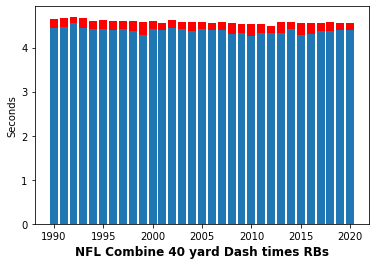

In [94]:
plt.bar(cSpd.Year, cSpd.RB_40_BEST)
plt.bar(cSpd.Year, cSpd.RB_40_Diff, color='r', label='40 Yard Dash Times', bottom=cSpd.RB_40_BEST)
plt.xlabel('NFL Combine 40 yard Dash times RBs', fontsize=12, weight='bold')
plt.ylabel('Seconds')

Text(0, 0.5, 'Seconds')

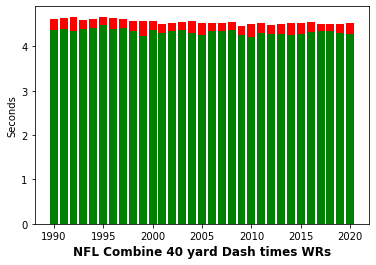

In [95]:
plt.bar(cSpd.Year, cSpd.WR_40_BEST, color='g')
plt.bar(cSpd.Year, cSpd.WR_40_Diff, color='r', bottom=cSpd.WR_40_BEST)
plt.xlabel('NFL Combine 40 yard Dash times WRs', fontsize=12, weight='bold')
plt.ylabel('Seconds')